## Experimentation with GravNet_Conv

In [1]:
import torch
import os
import tarfile
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mh_gravnet import MHGravNetConv

from gnn_tracking.metrics.losses import (
    PotentialLoss,
    BackgroundLoss,
)

### 1. Obtain data for training

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Current device:", device)

Current device: cuda


In [3]:
raw_data_dir = "../raw_data"    # Directory for raw data file
output_dir = "../data"          # Directory for outputs to print

In [4]:
for filename in os.listdir(raw_data_dir):
    if filename.endswith(".tar.gz"):
        tar_gz_path = os.path.join(raw_data_dir, filename)
        tar = tarfile.open(tar_gz_path, "r:gz")
        tar.extractall(output_dir)
        tar.close()

In [5]:
raw_data = []

for foldername in os.listdir(output_dir):
    folder = os.path.join(output_dir, foldername)
    for filename in os.listdir(folder):
        if filename.endswith(".pt"):
            file = os.path.join(folder, filename)
            raw_data.append(torch.load(file).to(device))

random.shuffle(raw_data)

In [6]:
# Train-Test split

split_index = round(len(raw_data)*0.8)
train_data = raw_data[:split_index]
test_data = raw_data[split_index:]

### 2. Observe point cloud properties

In [7]:
print("Length of dataset:", len(train_data))
print("Dimensions of sample point cloud", train_data[0].x.size())
print("Dimensions of sample IDs", train_data[0].particle_id.size())
print("Unique ID Values", torch.unique(train_data[0].particle_id).size())

Length of dataset: 720
Dimensions of sample point cloud torch.Size([6928, 14])
Dimensions of sample IDs torch.Size([6928])
Unique ID Values torch.Size([1057])


### 3. Loss function initializatinon

In [8]:
# Measures average ratio between intra and inter cluster hit distances
# Acts as a heuristic for cluster quality

def accuracy(x, id, n=50):
    mean_distance = 0
    cluster_distance = 0
    for i in range(n):
        rb = random.randint(0, len(id) - 1)
        ra = random.randint(0, len(id) - 1)
        ri = random.randint(0, len(id) - 1)

        masked_x = x[id == id[ri]]
        rbd = random.randint(0, len(masked_x) - 1)
        rad = random.randint(0, len(masked_x) - 1)
        mean_distance += torch.sqrt(((x[ra] - x[rb])**2).sum())
        cluster_distance += torch.sqrt(((masked_x[rbd] - masked_x[rad])**2).sum())
    
    return (cluster_distance/mean_distance).item()

In [9]:
# Object condensation loss function

p_loss = PotentialLoss(q_min=0.34, radius_threshold=3.7, attr_pt_thld=0.9)
b_loss = BackgroundLoss(sb=0.09)

def loss_function(x, beta, p_cloud):
    full_mask = torch.ones_like(p_cloud.particle_id).bool()
    p_l = p_loss.forward(beta=beta, x=x, particle_id=p_cloud.particle_id, reconstructable=p_cloud.reconstructable, track_params=full_mask, ec_hit_mask=full_mask)
    b_l = b_loss.forward(beta=beta, particle_id=p_cloud.particle_id, ec_hit_mask=full_mask)

    return p_l['attractive'] + 0.32355038938239544*p_l['repulsive'] + 0.0041*b_l

#### 4. Model Architecture

In [10]:
class Model(torch.nn.Module):
    def __init__(self, embed_dim, map_dim, intermediate_dim, k, num_heads=1, num_layers=4):
        super(Model, self).__init__()
        self.gravnets = torch.nn.ModuleList()
        self.gravnets.append(MHGravNetConv(in_channels=14, out_channels=embed_dim, space_dimensions=map_dim, propagate_dimensions=intermediate_dim, k=k, num_heads=num_heads))
        for _ in range(num_layers - 1):
            self.gravnets.append(MHGravNetConv(in_channels=embed_dim, out_channels=embed_dim, space_dimensions=map_dim, propagate_dimensions=intermediate_dim, k=k, num_heads=num_heads))
        self.final_layer = torch.nn.Linear(embed_dim, 5)

        self.activation = torch.nn.LeakyReLU()
        self.normalizing_factor = None
        self.embed_dim = embed_dim

    def forward(self, x, drop=False):

        for i in range(len(self.gravnets)):
            x = self.activation(self.gravnets[i](x, drop))
        x = self.final_layer(x)

        if self.normalizing_factor == None:
            self.normalizing_factor = torch.abs(x).mean().item()
        
        y = x/self.normalizing_factor

        return y[:, 1:], torch.sigmoid(y[:, 0])

### 5. Training Loop

##### Test model, four heads

In [11]:
gravnet = Model(embed_dim=64, map_dim=4, intermediate_dim=32, k=4, num_heads=4, num_layers=6).to(device)

In [15]:
lr = 0.0002     
optimizer = torch.optim.Adam(gravnet.parameters(), lr=lr, betas=(0.9, 0.999))

In [13]:
data_index = 0
loss_storage = []
iteration = 0
smoothed_loss = 1
smoothed_acc = 1

In [18]:
batch_size = 4

In [20]:
while True:
    iteration += batch_size
    optimizer.zero_grad()

    for i in range(batch_size):
        x, beta = gravnet(train_data[data_index + i].x, False)
        if i == 0:
            loss = loss_function(x, beta, train_data[data_index + i])/batch_size
        else:
            loss += loss_function(x, beta, train_data[data_index + i])/batch_size
    
    smoothed_loss = smoothed_loss*0.99 + loss.item()*0.01
    smoothed_acc = smoothed_acc*0.99 + accuracy(x, train_data[data_index + batch_size - 1].particle_id)*0.01
    print("Iteration:", iteration, "Total Loss: ", smoothed_loss, "Acc:", smoothed_acc)
    loss_storage.append(smoothed_loss)

    loss.backward()
    optimizer.step()
    data_index += batch_size

    if(data_index + batch_size >= len(train_data)):
        data_index = 0
        random.shuffle(train_data)
        train_data[0].x.size()

# Cleared training output due to length

Iteration: 33559 Total Loss:  0.14435542532739645 Acc: 0.011977761071518513
Iteration: 33563 Total Loss:  0.1442255249604407 Acc: 0.01194427613184303
Iteration: 33567 Total Loss:  0.14441530583053577 Acc: 0.011949053687754228
Iteration: 33571 Total Loss:  0.1443904845016425 Acc: 0.011961692874082849
Iteration: 33575 Total Loss:  0.1441570255673183 Acc: 0.011924668145829872
Iteration: 33579 Total Loss:  0.1441467344940792 Acc: 0.011920127883779894
Iteration: 33583 Total Loss:  0.1439860559283971 Acc: 0.01189790729217292
Iteration: 33587 Total Loss:  0.14384312627826995 Acc: 0.011900525373317157
Iteration: 33591 Total Loss:  0.14378801630073504 Acc: 0.011906018594926975
Iteration: 33595 Total Loss:  0.14359638976228611 Acc: 0.011873868742462115
Iteration: 33599 Total Loss:  0.14316775531372083 Acc: 0.01186553891436493
Iteration: 33603 Total Loss:  0.14295279355836554 Acc: 0.011851113329349688
Iteration: 33607 Total Loss:  0.1427195248829595 Acc: 0.011860503090787473
Iteration: 33611 Tota

IndexError: list index out of range

### 6. Evaluate Model

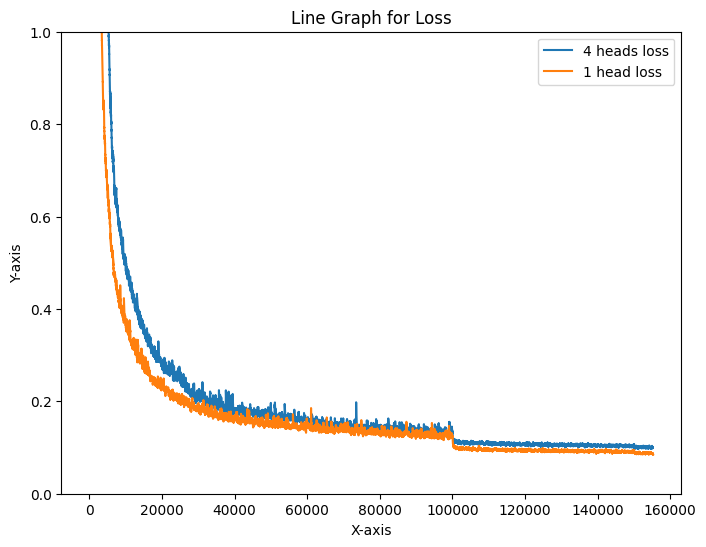

In [81]:
plt.figure(figsize=(8, 6))

sns.lineplot(x=range(len(loss_storage)), y=loss_storage, label="4 heads loss")
sns.lineplot(x=range(len(loss_storage2)), y=loss_storage2, label="1 head loss")

plt.title('Line Graph for Loss')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.gca().set_ylim(0, 1)

plt.legend()
plt.show()

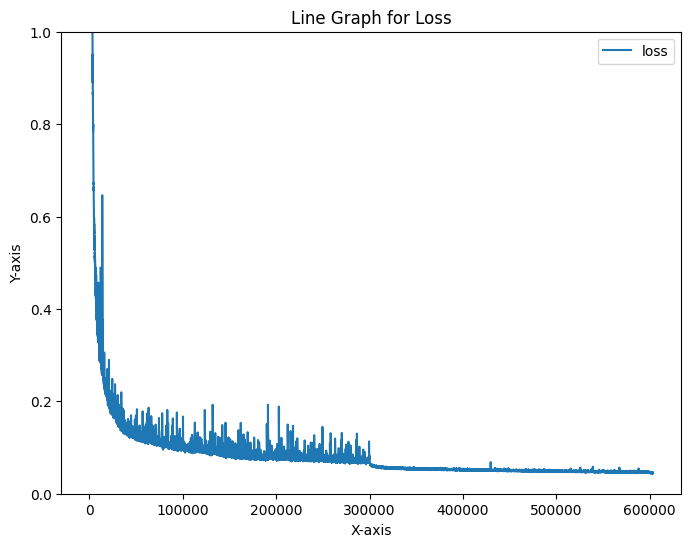

In [145]:
plt.figure(figsize=(8, 6))

sns.lineplot(x=range(len(loss_storage)), y=loss_storage, label="loss")

plt.title('Line Graph for Loss')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.gca().set_ylim(0, 1)

plt.legend()
plt.show()

In [114]:
# Function to calculate perfect match metric

from sklearn.cluster import DBSCAN

def perfect_match(input_tensor, ids, eps=0.3, min_samples=5):
    input_np = input_tensor.cpu().numpy()
    ids_np = ids.cpu().numpy()

    db = DBSCAN(eps=eps, min_samples=min_samples).fit(input_np)
    labels = db.labels_

    same_id_clusters = 0
    all_id_clusters = 0
    unique_labels = set(labels)

    for label in unique_labels:
        if label == -1:
            continue

        cluster_indices = (labels == label)
        cluster_ids = ids_np[cluster_indices]

        if np.all(cluster_ids == cluster_ids[0]):
            same_id_clusters += 1
            id_indices = (ids_np == cluster_ids[0])
            if np.all(cluster_indices == id_indices):
                all_id_clusters += 1

    return all_id_clusters/len(set(ids_np))

In [120]:
def cluster_scan(model, iterations=100, max_eps=2, max_pts=10):
    for min_pts in range(max_pts):
        best_result = 0
        best_iter = 0
        for i in range(iterations):
            sum = 0
            for data in test_data[:10]:
                res, _ = model(data.x)
                sum += perfect_match(res.detach(), data.particle_id, max_eps*((i + 1)/iterations), min_pts + 1)
            if(best_result < sum/10):
                best_result = sum/10
                best_iter = max_eps*((i + 1)/iterations)
        print("min_pts value:", min_pts + 1, "best eps:", best_iter, "perfect score:", best_result)

In [ ]:
cluster_scan(gravnet2, 40)

In [144]:
cluster_scan(gravnet, 100)

min_pts value: 1 best eps: 1.46 perfect score: 0.8827858569489688


KeyboardInterrupt: 

### 7. Visualise Model

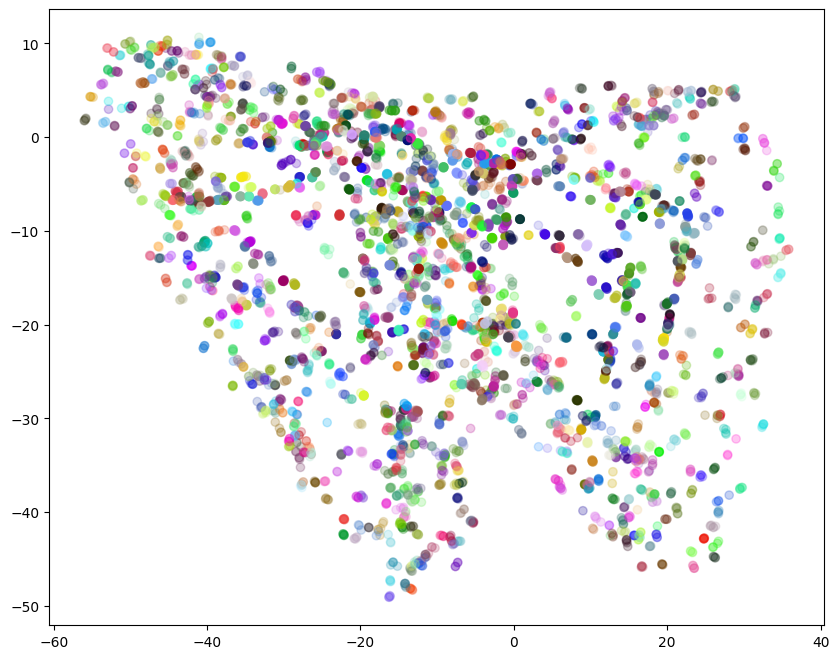

In [43]:
import random

y, _ = gravnet(raw_data[850].x)
POS = y.detach()
ID = raw_data[850].particle_id

id_np = ID.to('cpu').numpy()
pos_np = POS.to('cpu').numpy()

# Getting the unique IDs
unique_ids = np.unique(id_np)

# Create a dictionary to map IDs to random colors
id_color_dict = {unique_id: (random.random(), random.random(), random.random()) for unique_id in unique_ids}

# Use the dictionary to assign colors to IDs in your array
colors = [id_color_dict[id] for id in id_np]

plt.figure(figsize=(10, 8))
plt.scatter(pos_np[:, 0], pos_np[:, 1], color=colors, alpha=0.25)
plt.show()

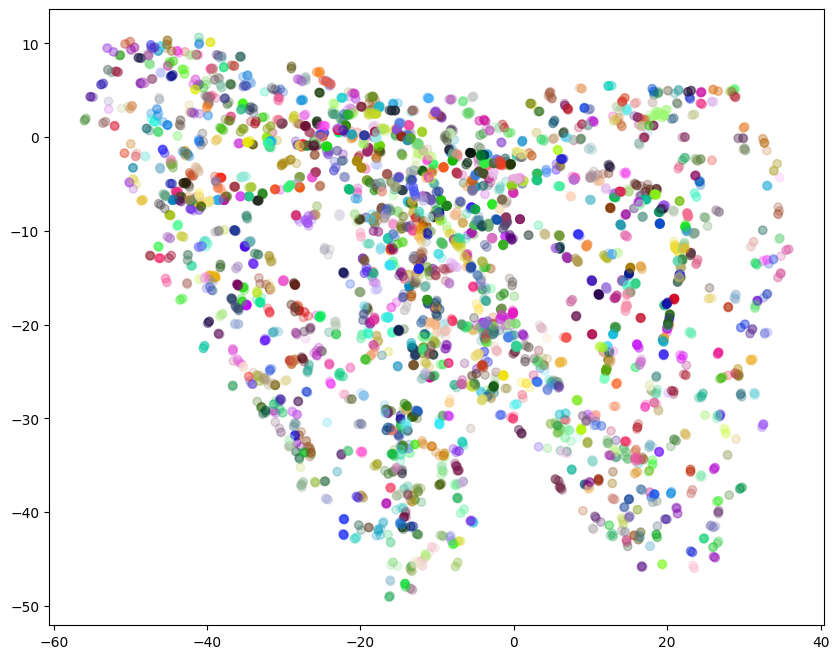

In [130]:
y, _ = gravnet(raw_data[850].x)
POS = y.detach()

input_np = POS.cpu().numpy()

db = DBSCAN(eps=1.15, min_samples=1).fit(input_np)
id_np = db.labels_

# Getting the unique IDs
unique_ids = np.unique(id_np)

# Create a dictionary to map IDs to random colors
id_color_dict = {unique_id: (random.random(), random.random(), random.random()) for unique_id in unique_ids}

# Use the dictionary to assign colors to IDs in your array
colors = [id_color_dict[id] for id in id_np]

plt.figure(figsize=(10, 8))
plt.scatter(pos_np[:, 0], pos_np[:, 1], color=colors, alpha=0.25)
plt.show()